Titanic Survival Prediction with PyTorch

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [4]:
# ---------------------------
# 1. Data Loading
# ---------------------------

file_path = '/content/clean-Titanic.csv'
df = pd.read_csv(file_path)
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns')



There are 1310 rows and 8 columns


In [7]:
# ---------------------------
# 2. Prepare Data for Neural Network
# ---------------------------

# Prepare features and target
X = df.drop('survived', axis=1).values
y = df['survived'].values.reshape(-1, 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

# Create DataLoader for batch processing
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)


In [8]:
# ---------------------------
# 3. Build Neural Network Model
# ---------------------------

class TitanicNN(nn.Module):
    def __init__(self, input_size):
        super(TitanicNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return self.sigmoid(x)



In [9]:
# ---------------------------
# 4. Training Setup
# ---------------------------

# Initialize the model
input_size = X_train.shape[1]
model = TitanicNN(input_size)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
# ---------------------------
# 5. Train the Model
# ---------------------------

# Training loop
epochs = 100
train_losses = []

for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')


Epoch [10/100], Loss: 0.4344
Epoch [20/100], Loss: 0.4132
Epoch [30/100], Loss: 0.4174
Epoch [40/100], Loss: 0.4138
Epoch [50/100], Loss: 0.4038
Epoch [60/100], Loss: 0.3974
Epoch [70/100], Loss: 0.4004
Epoch [80/100], Loss: 0.3905
Epoch [90/100], Loss: 0.3951
Epoch [100/100], Loss: 0.3994


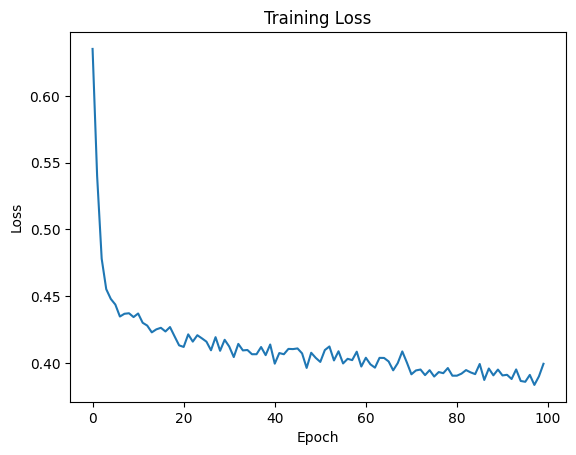

In [11]:
# ---------------------------
# 6. Evaluate the Model
# ---------------------------


# Plot training loss
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [12]:
# Evaluation
model.eval()
with torch.no_grad():
    y_pred_proba = model(X_test_tensor)
    y_pred = (y_pred_proba >= 0.5).float().numpy()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Accuracy: 0.79

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.91      0.83       150
         1.0       0.83      0.62      0.71       112

    accuracy                           0.79       262
   macro avg       0.80      0.77      0.77       262
weighted avg       0.79      0.79      0.78       262


Confusion Matrix:
[[136  14]
 [ 42  70]]


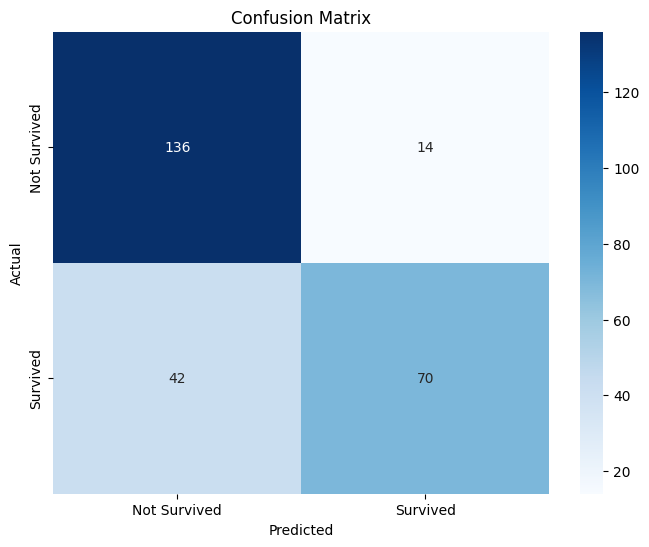

In [13]:
# ---------------------------
# 7. Visualization
# ---------------------------

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Survived', 'Survived'],
            yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


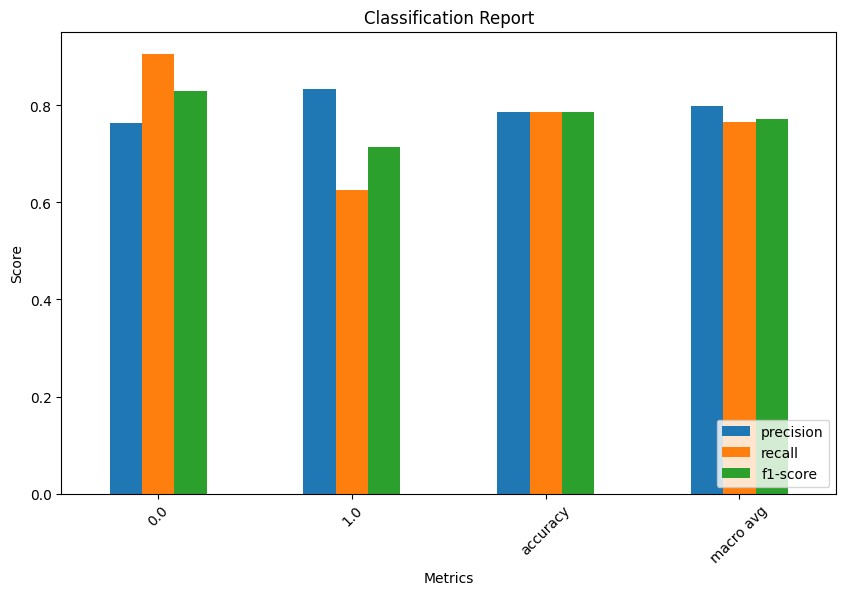

In [14]:
# Plot classification report
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.iloc[:-1, :-1].plot(kind='bar', figsize=(10, 6))
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.show()